In [25]:
import numpy as np
import matplotlib.pyplot as plt
# reflect points who get "dry" by streaming representing boundaries. e.g if you are at the bottom, reflect 4 to 2, i.e. f[2, 1, ] = f[4, 0, ]
# that is overwriting the streaming step
NX = 10
NY = 10
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])# weights, note that the last four (edges) 
# are the interpolation points with the highest velocity; weights influence probability density
c_ij = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])# velocities x and y component

In [26]:
# global density function
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX + 2, NY + 2)))# product of two arrays
f_inm[:, 0, :] = 0
f_inm[:, NX+1, :] = 0
f_inm[:, :, 0] = 0
f_inm[:, :, NY + 1] = 0
      
# extended density function with sourrounding for dry nodes
f_inm_ext = np.einsum('i,jk -> ijk', w_i, np.zeros((NX + 2, NY + 2)))

In [27]:
def dens_lattice_point(f_vxy):
    return np.einsum('vxy -> xy', f_vxy)

def vel_field_lattice_point(f_vxy):
    return 1/dens_lattice_point(f_vxy) * np.einsum('ij, ixy -> jxy', c_ij.T, f_vxy)

def stream(f_ijk):
    # define a velocity vector containing all shifting directions
    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]
    for p in range(1,9):
        f_ijk[p] = np.roll(f_ijk[p], shift=c_ij[p], axis=(0,1))
    return f_ijk

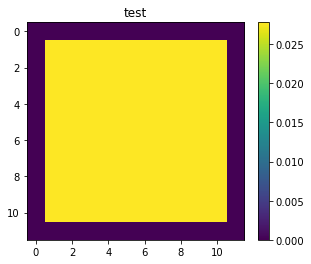

In [4]:
rho = dens_lattice_point(f_inm)
fig, ax = plt.subplots()
im = ax.imshow(f_inm[8])
plt.title("test")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

In [28]:
stream(f_inm)

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.44444444, 0.44444444, ..., 0.44444444,
         0.44444444, 0.        ],
        [0.        , 0.44444444, 0.44444444, ..., 0.44444444,
         0.44444444, 0.        ],
        ...,
        [0.        , 0.44444444, 0.44444444, ..., 0.44444444,
         0.44444444, 0.        ],
        [0.        , 0.44444444, 0.44444444, ..., 0.44444444,
         0.44444444, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        [0.        , 0.        , 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        ...,
        [0.        , 0.        , 0.11111111, ..., 0.11111111,
         0.11111111, 0.11111111],
        [0. 

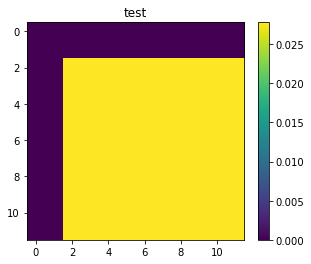

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(f_inm[8])
plt.title("test")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

In [29]:
def moving_wall():
    #calculate the values from Mohamad, used for the simulation of the moving wall
    rho_N = f_inm[0, 1, 1:NY+1] + f_inm[1, 1, 1:NY+1] + f_inm[0, 1, 1:NY+1] + f_inm[3, 1, 1:NY+1] + 2 * (f_inm[2, 1, 1:NY+1] + f_inm[6, 1, 1:NY+1] + f_inm[0, 1, 1:NY+1])
    f_inm[4, 1, :] = f_inm[2, 0, :]
    # velocity of moving wall
    u_N = 0.5
    for i in range(1, NY + 1):
        f_inm[7, 1, i] = f_inm[5, 0, i+1]
    f_inm[7, 1, 1:NY+1] += 1/2 * (f_inm[1, 1, 1:NY+1] - f_inm[3, 1, 1:NY+1]) - 1/2 * rho_N * u_N
    for j in range(NY + 1):
        f_inm[8, 1, j] = f_inm[6, 0, j-1]
    f_inm[8, 1, 1:NY+1] += 1/2 * (f_inm[3, 1, 1:NY+1] - f_inm[1, 1, 1:NY+1]) + 1/2 * rho_N * u_N
    # this operations should only change one X-line, but graphics show change in all lines

In [15]:
def correction_and_bounce_back():
    f_inm[5, 1:NX+1, 1] = f_inm[5, 1:NX+1, NY+1]
    f_inm[5, 1:NX+1, NY+1] = 0
    f_inm[5, 0, :] = 0
    f_inm[6, 1:NX+1 , NY] = f_inm[6, 1:NX+1, 0]
    f_inm[6, 1:NX+1, 0] = 0
    f_inm[6, 0, :] = 0
    # bottom boundary implemented as hard wall, reflecting the streaming impulses; this has to happen after the streaming step
    f_inm[2, 1, :] = f_inm[4, NX+1, :]
    for i in range(NY + 1):
        # northeast bounce back from left down corner to right down corner of wet nodes
        f_inm[5, NX, i] = f_inm[7, NX + 1, i-1]
    for j in range(1, NY+1):
        # northwest bounce back
        f_inm[6, NX , j] = f_inm[8, NX + 1, j+1]
    # values for the (1, :) Grid point of channels 7 and 8 already modified within the simulation of the moving wall
    f_inm[7, 2:NX+1, NY] = f_inm[7, 2:NX+1, 0]
    f_inm[7, 2:NX+1, 0] = 0
    f_inm[7, NX+1, :] = 0
    f_inm[8, 2:NX+1, 1] = f_inm[8, 2:NX+1, NX+1]
    f_inm[8, 2:NX+1, NX+1] = 0
    f_inm[8, NX+1, :] = 0
    # correct the streaming into dry nodes
    f_inm[1, 1:NX+1, 1] = f_inm[1, 1:NX+1, NY+1]
    f_inm[1, 1:NX+1, NY+1] = 0
    f_inm[2, NX, 1:NY+1] = f_inm[2, 0, 1:NY+1]
    f_inm[2, 0, 1:NY+1] = 0
    f_inm[3, 1:NX+1, NY] = f_inm[3, 1:NX+1, 0]
    f_inm[3, 1:NX+1, 0] = 0
    f_inm[4, 1, 1:NY+1] = f_inm[4, NX+1, 1:NY+1]
    f_inm[4, NX+1, 1:NY+1] = 0


In [34]:
moving_wall()
correction_and_bounce_back()

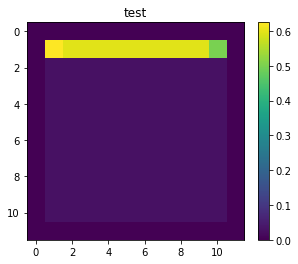

In [38]:

fig, ax = plt.subplots()
im = ax.imshow(f_inm[8])
plt.title("test")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

In [33]:
# implement dry nodes as 9 x NX + 2 x NY + 2 array for the "sourrounding" of our simulation domain. Then check for the "boundary"
# nodes if they will be streamed to a dry node and simulate the boudary impact
for i in range(500):
    stream(f_inm)

In [63]:
# literature: Mohamad: Lattice Boltzman Method p.72-78

rho = dens_lattice_point(f_inm)
u = vel_field_lattice_point(f_inm)
u_cut = u[:,:,9]
#fig, ax = plt.subplots()
#im = ax.imshow(u_cut)
#plt.plot(u_cut[0])
#plt.title("test")
#plt.colorbar(im,fraction=0.046, pad=0.04)
#plt.imshow(u_cut)
u_cut

array([[-0.2       , -0.2       , -0.2       , -0.2       , -0.23076923,
        -0.2       , -0.2       , -0.2       , -0.2       , -0.2       ,
         2.63636364, -0.2       ],
       [ 0.        , -0.2       , -0.2       , -0.2       , -0.15384615,
         0.        ,  0.        ,  0.        ,  0.2       ,  0.2       ,
         4.45454545,  0.        ]])

In [ ]:
# in the book: North boundary: v_N is zero as we have no velocity in the y direction here (sliding lid); only this flowing
# boundary is needed for the wet (?) and sliding lid; use v_n = 0 as we only have streaming (velocity) in x-direction

In [48]:
# moving speed of the upper wall will depend on viscosity
# initial for slices plot


x = np.arange(NX)
y = np.arange(NY)
X, Y = np.meshgrid(x,y)

In [50]:
%matplotlib notebook
fig, ax = plt.subplots()
for i in range(5):
    ax.plot(u[:,NX//2])
    u = np.zeros((NX, NY)) + (Y/NY) **i
plt.show()

<IPython.core.display.Javascript object>